# Processing LSCP results

Author: Kangdi Chen, Huanfa Chen

In [1]:
import datetime
print("Last update:", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

Last update: 19/06/2022 18:11:51


In [2]:
# !pip install inequality
# !pip install libpysal
# !pip install geopandas
# !pip3 install mapclassify

In [3]:
# !pip3 --no-cache-dir install inequality
# !pip3 install matplotlib_scalebar

In [4]:
# import mapclassify
# from google.colab import files 
import pandas
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
%pylab inline
# sys.path.append(os.path.abspath('..'))
import inequality
import libpysal 
import os
from matplotlib_scalebar.scalebar import ScaleBar

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [5]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import geopandas
# from libpysal.weights import Queen, Rook, KNN

In [6]:
folder_map_dpi_100 = '../Map/new_map_dpi100/'
folder_map_dpi_300 = '../Map/new_map_dpi300/'
def file_path_map(file_map, dpi=100):
    if dpi==100:
        return(os.path.join(folder_map_dpi_100, file_map))
    else:
        return(os.path.join(folder_map_dpi_300, file_map))

In [7]:
# the folder of data
folder_data = '../Data'

In [8]:
# serivce distance in metres
service_distance = 16093.4

# Summary of service levels before and after site optimisation

## Import MSOA data

In [9]:
gdf_MSOA_poly = geopandas.read_file(os.path.join(folder_data, 'MSOA_Boundary_with_population.gpkg'))
gdf_MSOA_poly = gdf_MSOA_poly.to_crs('epsg:4326')

In [10]:
gdf_MSOA_points = geopandas.read_file(os.path.join(folder_data, 'MSOA_Population_Weighted_Centroids_with_population.gpkg'))
gdf_MSOA_points = gdf_MSOA_points.to_crs('epsg:4326')

In [11]:
gdf_city_town = geopandas.read_file(os.path.join(folder_data, 'Major_Towns_and_Cities_December_2015_Boundaries'))
gdf_city_town = gdf_city_town.to_crs('epsg:4326')

In [12]:
gdf_MSOA_points.b_urban.value_counts()

False    3998
True     2793
Name: b_urban, dtype: int64

In [13]:
# why is this needed?
# get the outline of England
gdf_MSOA_poly['dissolve']=1
gdf_MSOA_outline = gdf_MSOA_poly.dissolve(by='dissolve')

## Import distance df and compute sevice levels

In [14]:
# import distance dataframe
distance_df_existing_sites_MSOA = pandas.read_csv(os.path.join(folder_data, 'distance_df_existing_sites_MSOA.csv'))

In [15]:
# get the list of origin_id and the number of vaccination sites within the service distance (10 miles) of each MSOA
# distance_df_existing_sites_MSOA = distance_df_existing_sites_MSOA.loc[distance_df_existing_sites_MSOA.d]
df_MSOA_number_sites = distance_df_existing_sites_MSOA.groupby('origin_id').size().reset_index(name = 'number')
# note that if an MSOA is not covered by existing sites, it is not in df_MSOA_number_sites 

In [16]:
distance_df_existing_sites_MSOA.head(5)

,Unnamed: 0,origin_id,dest_id,distance
0,122,E02002536,E122,6712.7
1,127,E02002536,E127,13881.2
2,137,E02002536,E137,13631.4
3,836,E02002536,E836,12395.3
4,838,E02002536,E838,12672.0


In [17]:
df_MSOA_number_sites.head(5)

,origin_id,number
0,E02000001,623
1,E02000002,69
2,E02000003,68
3,E02000004,42
4,E02000005,73


## Remove the three inaccessible MSOAs

In [18]:
array_MSOA_ID = df_MSOA_number_sites.origin_id.unique()
# read the list of MSOAs that can be covered by potential sites
df_uncoverd_MSOA = pandas.read_csv(os.path.join(folder_data, 'Uncovered_MSOA_380.csv'))
# combine two lists
array_MSOA_ID = np.append(array_MSOA_ID, df_uncoverd_MSOA.MSOA_ID)

In [19]:
gdf_MSOA_points = gdf_MSOA_points[gdf_MSOA_points.msoa11cd.isin(array_MSOA_ID)]
gdf_MSOA_poly = gdf_MSOA_poly[gdf_MSOA_poly.msoa11cd.isin(array_MSOA_ID)]
gdf_MSOA_outline = gdf_MSOA_poly.dissolve(by='dissolve')

## Summary of service levels before optimisation

In [20]:
gdf_MSOA_points = gdf_MSOA_points.merge(df_MSOA_number_sites, left_on='msoa11cd', right_on='origin_id', how = 'left')
gdf_MSOA_points = gdf_MSOA_points.fillna({'number':0})

In [21]:
gdf_MSOA_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6788 entries, 0 to 6787
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   6788 non-null   int64   
 1   msoa11cd   6788 non-null   object  
 2   pop0-49    6788 non-null   int64   
 3   pop50-59   6788 non-null   int64   
 4   pop60-69   6788 non-null   int64   
 5   pop70-79   6788 non-null   int64   
 6   pop80-89   6788 non-null   int64   
 7   pop90+     6788 non-null   int64   
 8   total_pop  6788 non-null   int64   
 9   b_urban    6788 non-null   bool    
 10  geometry   6788 non-null   geometry
 11  origin_id  6408 non-null   object  
 12  number     6788 non-null   float64 
dtypes: bool(1), float64(1), geometry(1), int64(8), object(2)
memory usage: 696.0+ KB


In [22]:
def quantile_(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = '{:2.0f}%'.format(n*100)
    return percentile_

In [23]:
# number_tmp = gdf_MSOA_points.number.reset_index()
result = inequality.gini.Gini([1,2,3])
result.g

0.2222222222222222

In [24]:
def gini_coef(x):
# compute the gini coefficient of a array-like object.
# passed to the groupby().agg() function
    return inequality.gini.Gini(np.array(x)).g
gini_coef.__name__ = 'Gini index'

In [25]:
def summary_df(x):
# summary of a dataframe with the column of 'number'
    return x.agg(['min', quantile_(0.25), 'median', quantile_(0.75), 'max', 'mean', gini_coef])

In [26]:
# def number_uncovered(x):
# # compute the gini coefficient of a array-like object.
# # passed to the groupby().agg() function
#     return x.value_counts()[0]
# number_uncovered.__name__ = ''

In [27]:
df_compare_service_coverage = gdf_MSOA_points[['b_urban','number']].groupby('b_urban').agg(['min', quantile_(0.25), 'median', quantile_(0.75), 'max', 'mean', gini_coef])
# df_compare_service_coverage = gdf_MSOA_points[['b_urban','number']].groupby('b_urban').agg(['min', quantile_(0.25), 'median', quantile_(0.75), 'max', 'mean'])
# df_compare_service_coverage = gdf_MSOA_points[['b_urban','number']].groupby('b_urban').agg(['min'])
# df_compare_service_coverage = gdf_MSOA_points[['b_urban','number']].groupby('b_urban').agg([percentile(25)])
df_compare_service_coverage

number                                                 
           min  25% median    75%    max        mean Gini index
b_urban                                                        
False      0.0  2.0    4.0    8.0  610.0    7.617272   0.630969
True       0.0  6.0   12.0  151.0  659.0  122.755102   0.733834

In [28]:
def summary_service_level_all_urban_rural(df_service, col_number_sites):
    df_compare_service = pandas.concat(
        [summary_df(df_service[[col_number_sites]]),
        summary_df(df_service.loc[df_service.b_urban==True][[col_number_sites]]),
        summary_df(df_service.loc[df_service.b_urban==False][[col_number_sites]])
        ], axis=1)
    df_compare_service.columns = ['Overall', 'Urban', 'Rural']
    return(df_compare_service)

In [29]:
df_compare_service = summary_service_level_all_urban_rural(gdf_MSOA_points, 'number')
df_compare_service.to_csv(os.path.join(folder_data, 'summary_service_coverage_before_opt.csv'))
# df_compare_service.to_clipboard()

In [30]:
df_compare_service.head(5)

,Overall,Urban,Rural
min,0.0,0.0,0.0
25%,3.0,6.0,2.0
median,6.0,12.0,4.0
75%,13.0,151.0,8.0
max,659.0,659.0,610.0


## Summary of service levels after optimisation

In [31]:
# import selected sites for all MSOAs
df_sites_for_all_MSOAs = pandas.read_csv(os.path.join(folder_data, 'df_LSCP_facility_ID_for_all_MSOAs.csv'))

In [32]:
df_sites_for_all_MSOAs.shape

(313, 1)

### import and merge distance df

In [33]:
# import distance dataframe
df_distance_existing_sites_covered_MSOA = pandas.read_csv(os.path.join(folder_data, 'distance_df_existing_sites_MSOA.csv'))
df_distance_potential_sites_all_MSOA = pandas.read_csv(os.path.join(folder_data, 'distance_df_potential_sites_all_MSOA.csv'))

In [34]:
# combine two distance df
df_distance_existing_potential_sites_all_MSOAs = pandas.concat([df_distance_existing_sites_covered_MSOA, df_distance_potential_sites_all_MSOA], ignore_index=False)

In [35]:
df_distance_existing_potential_sites_all_MSOAs.shape[0]

2611068

In [36]:
print("How many MSOAs in this distance df? {}".format(df_distance_existing_potential_sites_all_MSOAs.origin_id.unique().size))
print("How many sites in this distance df? {}".format(df_distance_existing_potential_sites_all_MSOAs.dest_id.unique().size))

How many MSOAs in this distance df? 6788
How many sites in this distance df? 22727


In [37]:
# retain only the dest_id that are in the selected sites
df_distance_selected_sites = df_distance_existing_potential_sites_all_MSOAs.loc[df_distance_existing_potential_sites_all_MSOAs.dest_id.isin(df_sites_for_all_MSOAs.site_ID)]

In [38]:
print("How many MSOAs in this distance df? {}".format(df_distance_selected_sites.origin_id.unique().size))
print("How many sites in this distance df? {}".format(df_distance_selected_sites.dest_id.unique().size))

How many MSOAs in this distance df? 6788
How many sites in this distance df? 313


In [39]:
# remove distance of NA or greater than service_distance
df_distance_selected_sites = df_distance_selected_sites.loc[(df_distance_selected_sites.distance.notna()) & (df_distance_selected_sites.distance < service_distance), ]

In [40]:
df_distance_selected_sites.distance.describe()

count     8924.000000
mean      9967.864892
std       4278.015370
min         87.600000
25%       6705.325000
50%      10695.450000
75%      13674.750000
max      16093.300000
Name: distance, dtype: float64

In [41]:
# check
# how many unique origin_id in this df? Should be 4913
print('unique MSOAs:{}'.format(df_distance_selected_sites.origin_id.unique().size))
# how many NA values? N
print('Invalid distance:{}'.format(df_distance_selected_sites.distance.isna().sum()))

unique MSOAs:6788
Invalid distance:0


In [42]:
# get the list of origin_id and the number of vaccination sites within the service distance (10 miles) of each MSOA
# distance_df_existing_sites_MSOA = distance_df_existing_sites_MSOA.loc[distance_df_existing_sites_MSOA.d]
df_MSOA_number_sites_after_opt = df_distance_selected_sites.groupby('origin_id').size().reset_index(name = 'number')
# note that if an MSOA is not covered by existing sites, it is not in df_MSOA_number_sites 

In [43]:
df_MSOA_number_sites_after_opt.shape[0]

6788

In [44]:
df_MSOA_number_sites_after_opt = df_MSOA_number_sites_after_opt.merge(gdf_MSOA_points[['msoa11cd', 'b_urban']], how = 'left', left_on = 'origin_id', right_on = 'msoa11cd', validate = 'one_to_one')
df_compare_service_after_opt = summary_service_level_all_urban_rural(df_MSOA_number_sites_after_opt, 'number')
df_compare_service_after_opt.to_csv(os.path.join(folder_data, 'summary_service_coverage_after_opt.csv'))
# df_compare_service_after_opt.to_clipboard()

In [45]:
df_MSOA_number_sites_after_opt.b_urban.value_counts()

False    3995
True     2793
Name: b_urban, dtype: int64

In [46]:
df_compare_service_after_opt.head(5)

,Overall,Urban,Rural
min,1.0,1.0,1.0
25%,1.0,1.0,1.0
median,1.0,1.0,1.0
75%,2.0,2.0,2.0
max,3.0,3.0,3.0


# Plotting

## Maps of service levels before optimisation

A few key questions:
1. How are the intervals determined? Can I use natural breaks?
2. A more efficient way to plot the heatmap?

In [47]:
# merge boundary with service level
gdf_MSOA_poly_before_opt=pandas.merge(left = gdf_MSOA_poly,right = df_MSOA_number_sites, how='left', left_on='msoa11cd', right_on='origin_id')
gdf_MSOA_poly_before_opt = gdf_MSOA_poly_before_opt.fillna({'number':0})

In [48]:
gdf_MSOA_poly_before_opt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6788 entries, 0 to 6787
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   msoa11cd   6788 non-null   object  
 1   MSOA11NM   6788 non-null   object  
 2   pop0-49    6788 non-null   int64   
 3   pop50-59   6788 non-null   int64   
 4   pop60-69   6788 non-null   int64   
 5   pop70-79   6788 non-null   int64   
 6   pop80-89   6788 non-null   int64   
 7   pop90+     6788 non-null   int64   
 8   total_pop  6788 non-null   int64   
 9   b_urban    6788 non-null   bool    
 10  geometry   6788 non-null   geometry
 11  dissolve   6788 non-null   int64   
 12  origin_id  6408 non-null   object  
 13  number     6788 non-null   float64 
dtypes: bool(1), float64(1), geometry(1), int64(8), object(3)
memory usage: 749.1+ KB


In [49]:
gdf_MSOA_outline = gdf_MSOA_poly.dissolve(by='dissolve')

In [50]:
# remove rows of gdf_city_town that are not inside gdf_MSOA_outline
gdf_city_town_tmp = geopandas.overlay(gdf_city_town,gdf_MSOA_outline, how='intersection')

In [51]:
# pip install pygeos

In [52]:
# function for scale bar
# Source code from: https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot
import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.

    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        return geodesic.inverse(a_phys, b_phys).base[0, 0]

    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.

    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.

    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)

In [53]:
# another way to add a scale bar of 10km
# https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html
from shapely.geometry.point import Point

points = geopandas.GeoSeries([Point(-73.5, 50), Point(-74.5, 50)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters

distance_meters = points[0].distance(points[1])

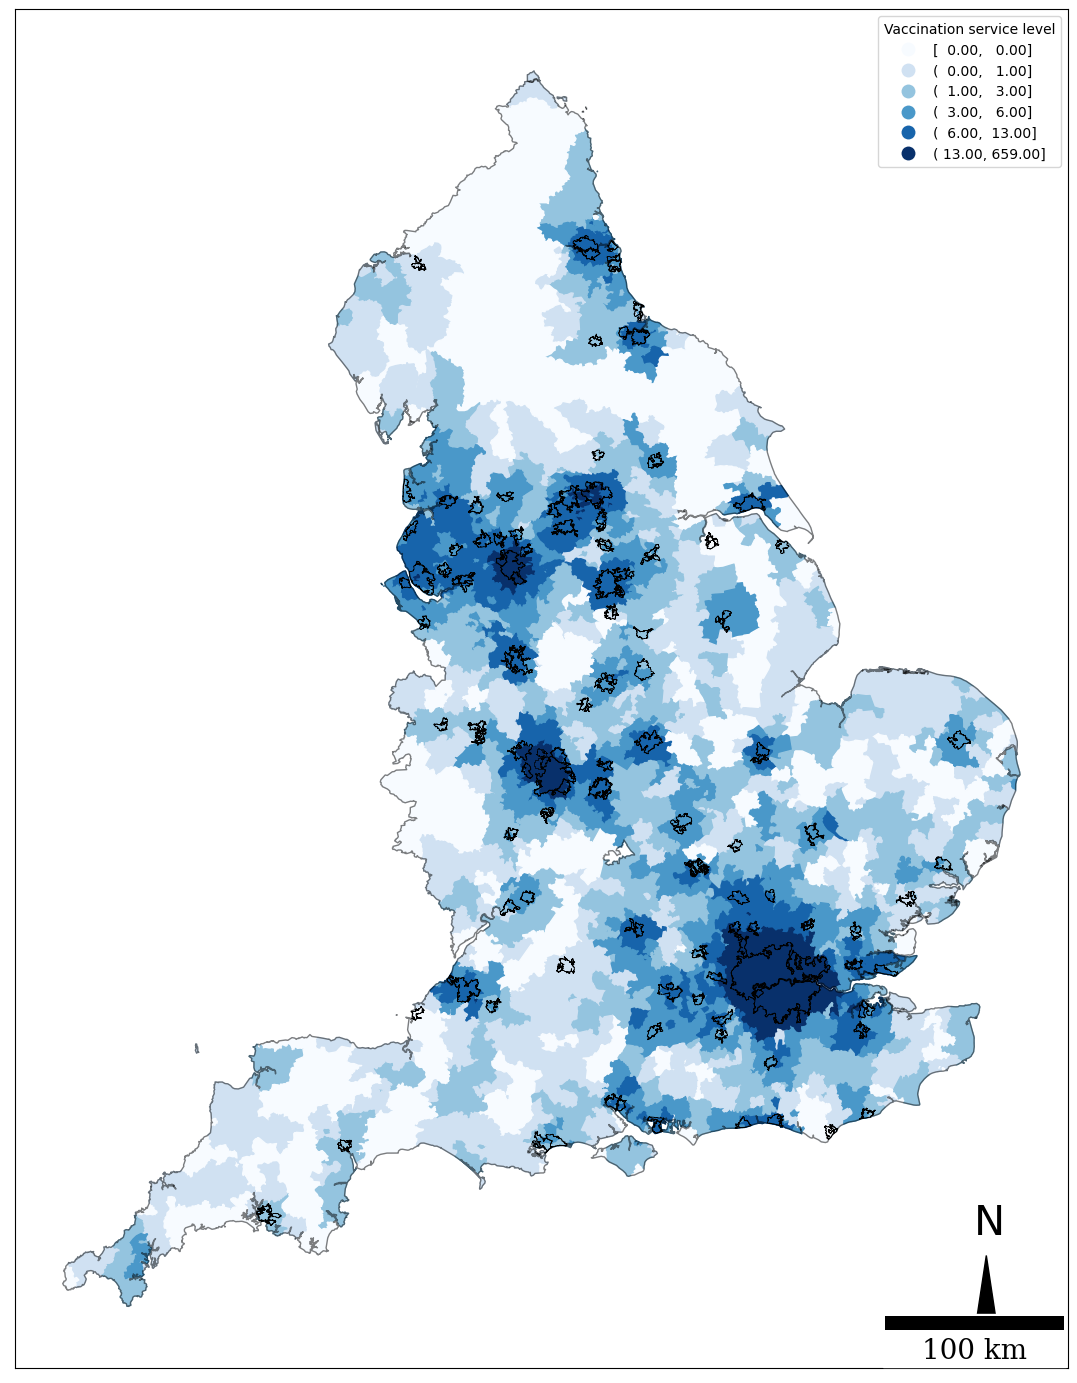

In [54]:
# the intervals of the colour bins are the quantiles of service level plus the zero value (in order to highlight the underserved areas)
fig, ax = plt.subplots(figsize=(18,18),dpi=100)
# ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
# scheme='User_Defined' allows predefined bin values
# classification_kwds contains a list of intervals, but the min and max values are derived from data
gdf_MSOA_poly_before_opt.plot(column='number', cmap='Blues', scheme="User_Defined", 
edgecolor='face',
         legend=True, classification_kwds=dict(bins=[0,1,3,6,13]),
         legend_kwds={
            #  'loc': 'center left', 
            #  'bbox_to_anchor':(1,0.5),
             'interval': True,
             'title':'Vaccination service level'
            },
         ax=ax)
gdf_MSOA_outline.plot(edgecolor=(0, 0, 0,0.5), facecolor='none', linewidth=1,ax=ax)

# plot urban and rural boundary
gdf_city_town_tmp.plot(edgecolor='black', facecolor='none', linewidth=0.5,ax=ax)

# add north arrow
ax.text(x=1.4, y=50.3, s='N', fontsize=30)
ax.arrow(1.5, 50, 0, 0.2, length_includes_head=True,
   head_width=.2, head_length=.4, overhang=.1, facecolor='k')
# scale bar
ax.add_artist(ScaleBar(distance_meters, location = 'lower right', font_properties={'family':'serif', 'size': 20},))
plt.show()

fig.savefig(file_path_map('Map_before_opt_300.tif', dpi=300), dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
fig.savefig(file_path_map('Map_before_opt_100.tif', dpi=100), dpi=100, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')

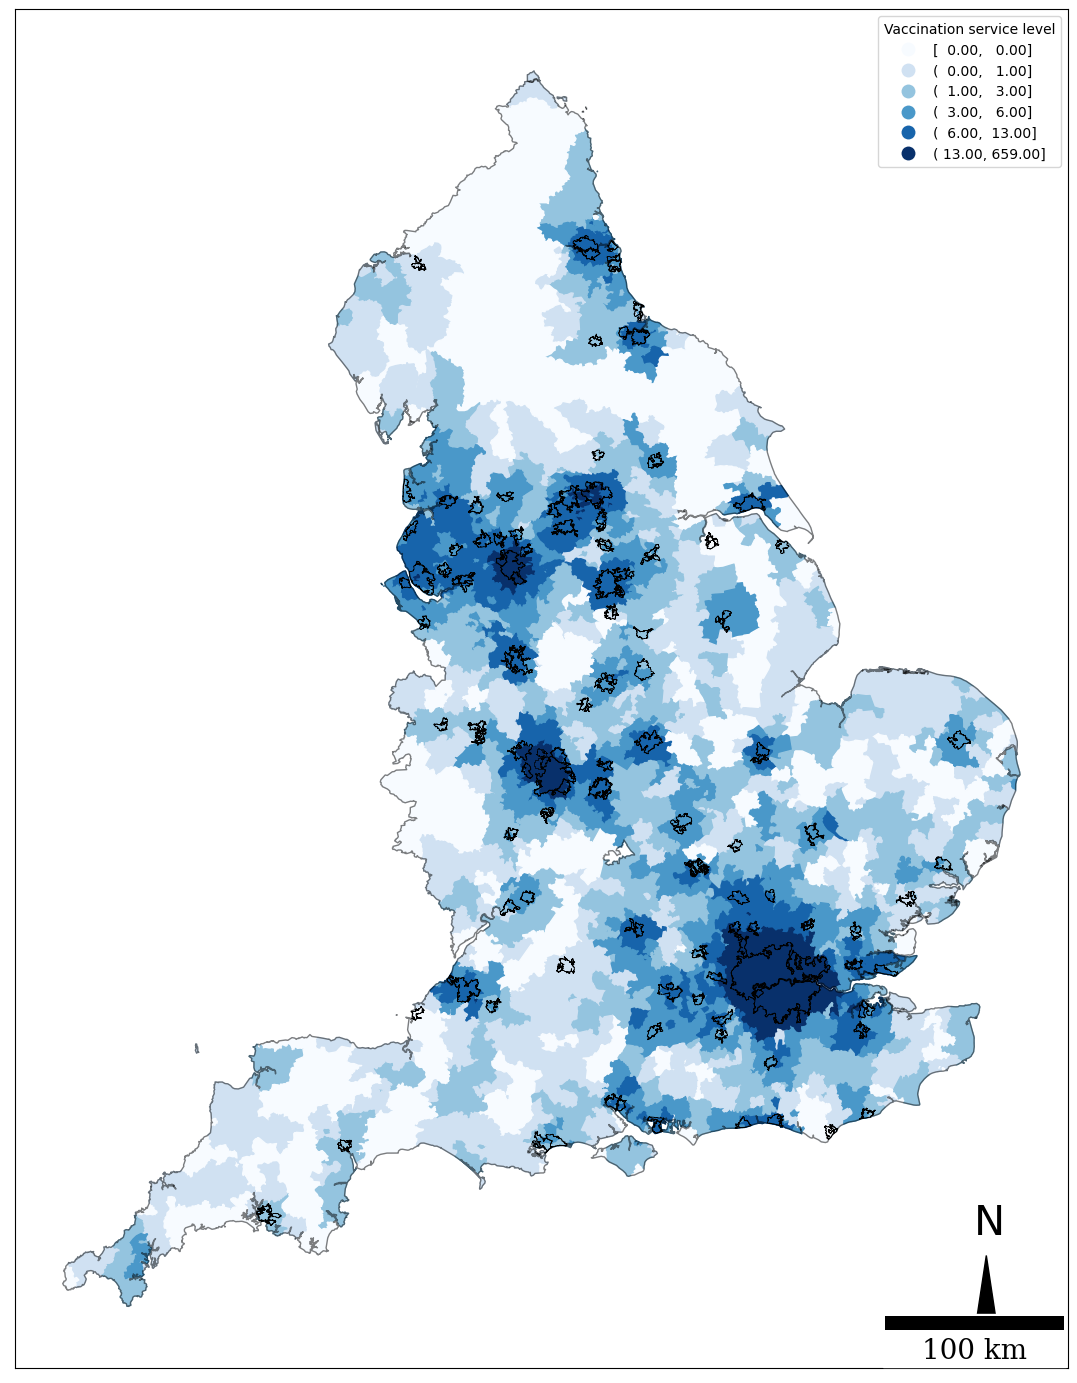

In [55]:
# test natural break
# https://geopandas.org/en/stable/gallery/choropleths.html
fig, ax = plt.subplots(figsize=(18,18),dpi=100)
# ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
# scheme='User_Defined' allows predefined bin values
# classification_kwds contains a list of intervals, but the min and max values are derived from data
gdf_MSOA_poly_before_opt.plot(
   column='number', cmap='Blues',
   scheme="User_Defined", classification_kwds=dict(bins=[0,1,3,6,13]),
   # scheme="quantiles", k = 7,
   edgecolor='face',
   legend=True, 
         legend_kwds={
            #  'loc': 'center left', 
            #  'bbox_to_anchor':(1,0.5),
             'interval': True,
             'title':'Vaccination service level'
            },
         ax=ax)
gdf_MSOA_outline.plot(edgecolor=(0, 0, 0,0.5), facecolor='none', linewidth=1,ax=ax)

# plot urban and rural boundary
gdf_city_town_tmp.plot(edgecolor='black', facecolor='none', linewidth=0.5,ax=ax)

# add north arrow
ax.text(x=1.4, y=50.3, s='N', fontsize=30)
ax.arrow(1.5, 50, 0, 0.2, length_includes_head=True,
   head_width=.2, head_length=.4, overhang=.1, facecolor='k')
# scale bar
ax.add_artist(ScaleBar(distance_meters, location = 'lower right', font_properties={'family':'serif', 'size': 20},))
plt.show()

# fig.savefig(file_path_map('Map_before_opt_300.tif', dpi=300), dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
# fig.savefig(file_path_map('Map_before_opt_100.tif', dpi=100), dpi=100, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')

## Maps of service levels after optimisation

In [56]:
# load sites data
gdf_existing_sites = pandas.read_csv(os.path.join(folder_data, 'df_existing_sites.csv'))
gdf_existing_sites = geopandas.GeoDataFrame(gdf_existing_sites, geometry=geopandas.points_from_xy(gdf_existing_sites.long, gdf_existing_sites.lat),
crs='epsg:4326')
# gdf_MSOA_poly = gdf_MSOA_poly.to_crs('epsg:4326')

gdf_potential_sites = pandas.read_csv(os.path.join(folder_data, 'df_potential_site_for_uncovered_MSOAs.csv'))
gdf_potential_sites = geopandas.GeoDataFrame(gdf_potential_sites, geometry=geopandas.points_from_xy(gdf_potential_sites.long, gdf_potential_sites.lat),
crs='epsg:4326')

# only keep the selected rows
gdf_existing_sites = gdf_existing_sites.loc[gdf_existing_sites.site_ID.isin(df_sites_for_all_MSOAs.site_ID)]
gdf_potential_sites = gdf_potential_sites.loc[gdf_potential_sites.site_ID.isin(df_sites_for_all_MSOAs.site_ID)]

In [57]:
print(gdf_existing_sites.shape[0] + gdf_potential_sites.shape[0])
print(df_sites_for_all_MSOAs.shape[0])

165
313


In [58]:
gdf_existing_sites.columns

Index(['Unnamed: 0', 'index', 'supply_value', 'long', 'lat', 'site_ID',
       'geometry'],
      dtype='object')

In [59]:
# merge boundary with service level
gdf_MSOA_poly_after_opt=pandas.merge(left = gdf_MSOA_poly,right = df_MSOA_number_sites_after_opt, how='left', left_on='msoa11cd', right_on='origin_id')
gdf_MSOA_poly_after_opt = gdf_MSOA_poly_after_opt.fillna({'number':0})

In [60]:
gdf_existing_sites.shape[0]

11

In [61]:
gdf_MSOA_poly_after_opt.number.value_counts()

1    4789
2    1862
3     137
Name: number, dtype: int64

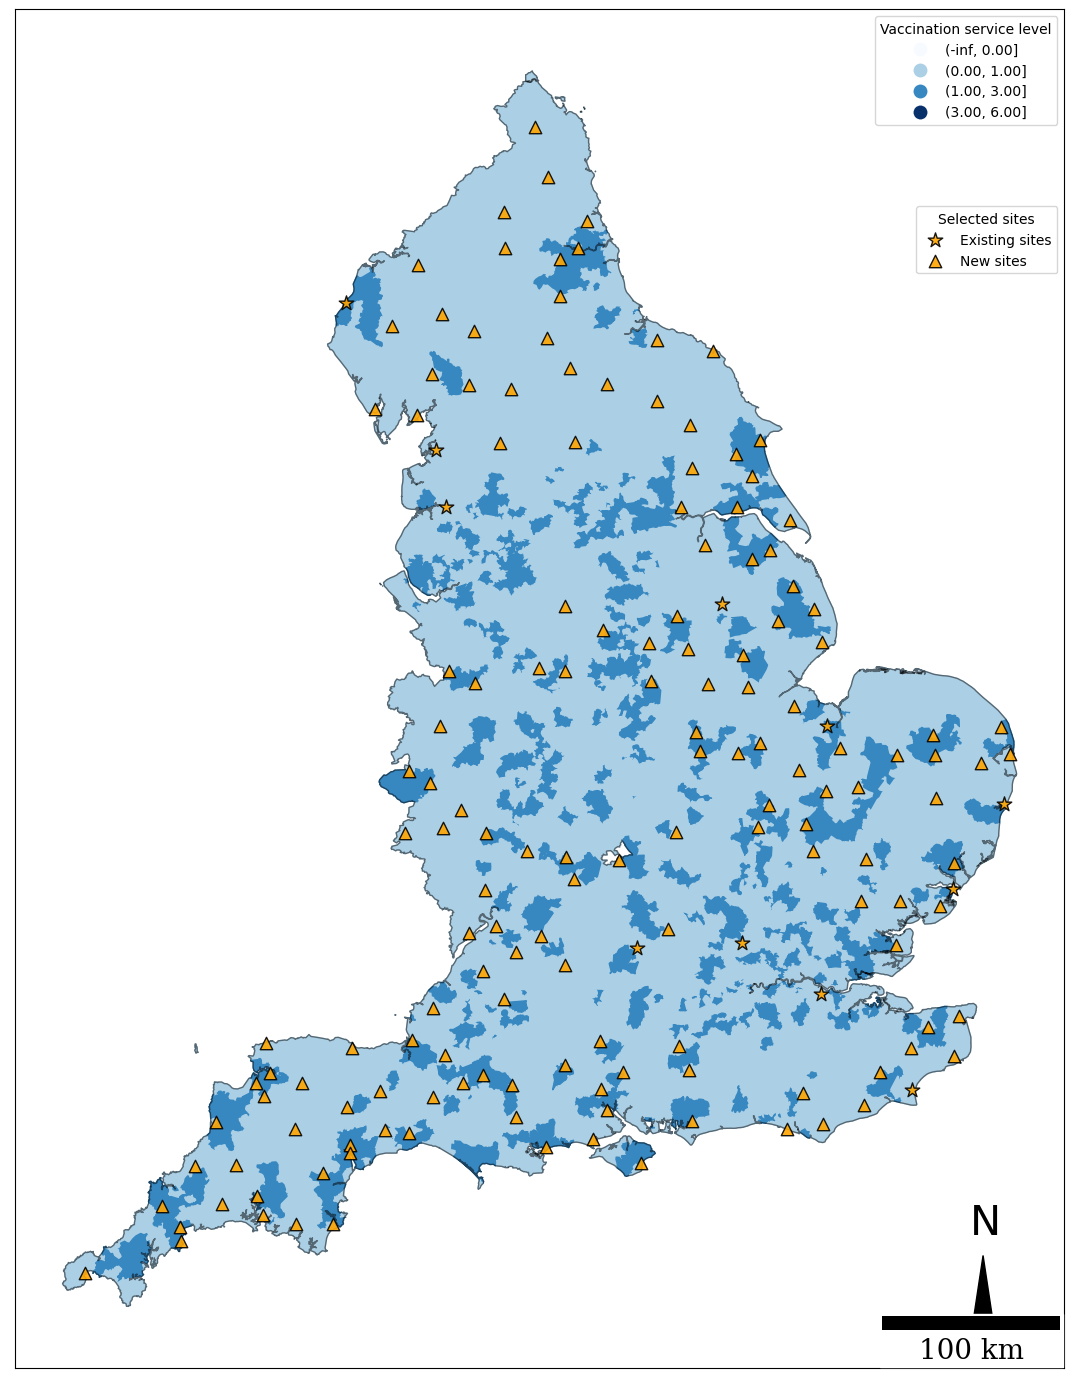

In [62]:
# the intervals of the colour bins are the same as the map of before opt
fig, ax = plt.subplots(figsize=(18,18),dpi=100)
# ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
# scheme='User_Defined' allows predefined bin values
# classification_kwds contains a list of intervals, but the min and max values are derived from data
plot_msoa = gdf_MSOA_poly_after_opt.plot(column='number', cmap='Blues', scheme="User_Defined", 
edgecolor='face',
         classification_kwds=dict(bins=[0,1,3,6]),
         legend=True, 
         legend_kwds={
            #  'loc': 'center left', 
            #  'bbox_to_anchor':(1,0.5),
             'interval': True,
             'title':'Vaccination service level'
            },
         ax=ax)
gdf_MSOA_outline.plot(edgecolor=(0, 0, 0,0.5), facecolor='none', linewidth=1,ax=ax)

# plot urban and rural boundary
# gdf_city_town_tmp.plot(edgecolor='black', facecolor='none', linewidth=0.5,ax=ax)

# plot selected existing sites

# plot selected potential sites

plot_existing_site = gdf_existing_sites.plot(ax=ax,
            marker="*",
            markersize=120,
            alpha=0.9,
            # zorder=4,
            edgecolor="k",
            facecolor='orange',
            label = 'Existing sites'
            # legend=True,
            # legend_kwds={
            #  'loc': 'center left', 
            # #  'bbox_to_anchor':(1,0.5),
            # #  'interval': True,
            #  'title':'Vaccination service level'
            # },
            )
plot_pontential_site = gdf_potential_sites.plot(ax=ax,
            marker="^",
            markersize=80,
            alpha=0.9,
            zorder=4,
            edgecolor="k",
            facecolor='orange',
            label = 'New sites'
            )

# TODO: combine all legends
# legend_plot_msoa = ax.legend(handles=[plot_msoa], loc='upper right')
# legend_plot_existing_site = ax.legend(handles=[plot_existing_site], loc='center right')
# ax.add_artist(legend_plot_msoa)

# get the current site (from geopandas plot)
first_legend = ax.get_legend()
# manually add it to ax
ax.add_artist(first_legend)
ax.legend(fontsize=10,
          frameon=True,
         #  loc=('center left'),
          bbox_to_anchor=(1,0.86),
          title="Selected sites")

# add north arrow
ax.text(x=1.4, y=50.3, s='N', fontsize=30)
ax.arrow(1.5, 50, 0, 0.2, length_includes_head=True,
   head_width=.2, head_length=.4, overhang=.1, facecolor='k')
# scale bar
ax.add_artist(ScaleBar(distance_meters, location = 'lower right', font_properties={'family':'serif', 'size': 20},))
plt.show()
fig.savefig(file_path_map('Map_sites_after_opt_300.tif', dpi=300), dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
fig.savefig(file_path_map('Map_sites_after_opt_100.tif', dpi=100), dpi=100, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')

## Maps of new sites for underserved MSOAs

In [63]:
print(df_uncoverd_MSOA.columns)
print(df_uncoverd_MSOA.shape[0])

Index(['Unnamed: 0', 'index', 'objectid', 'MSOA_ID', 'pop0-49', 'pop50-59',
       'pop60-69', 'pop70-79', 'pop80-89', 'pop90+', 'total_pop', 'geometry',
       'long', 'lat', 'MSOA_easting', 'MSOA_northing'],
      dtype='object')
380


<ipython-input-64-c8799278460b>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements.append(Patch(edgecolor=(0.8, 0, 0,0.8),color='tan',label='Underserved MSOAs'))


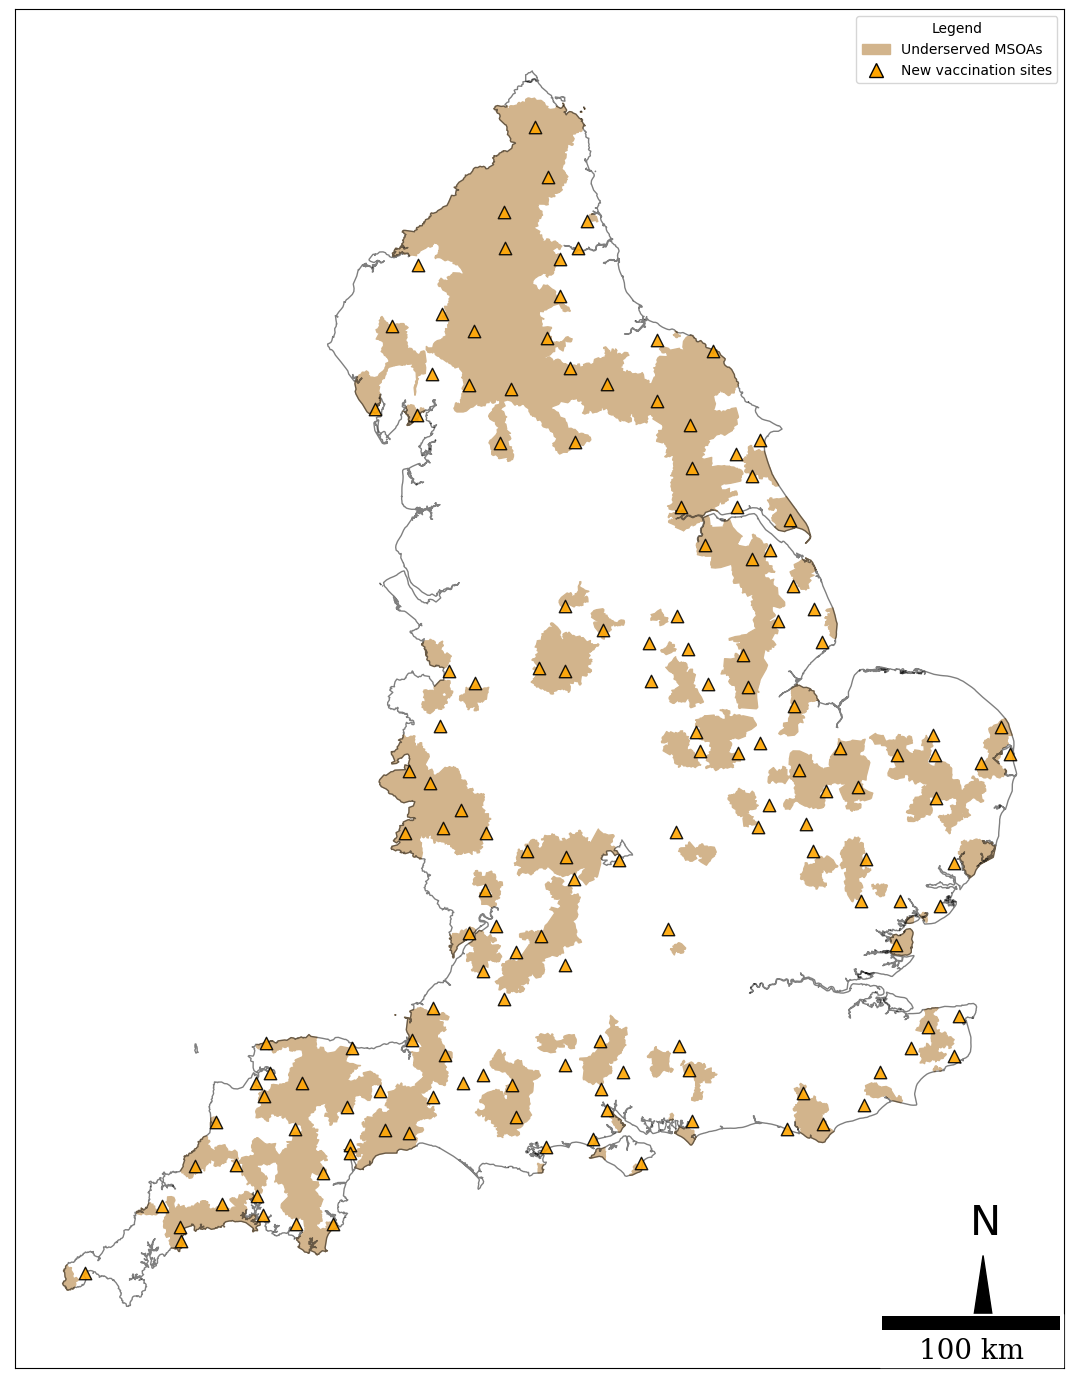

In [64]:
# the intervals of the colour bins are the same as the map of before opt
fig, ax = plt.subplots(figsize=(18,18),dpi=100)
# ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
# scheme='User_Defined' allows predefined bin values
# classification_kwds contains a list of intervals, but the min and max values are derived from data
plot_msoa = gdf_MSOA_poly.loc[gdf_MSOA_poly.msoa11cd.isin(df_uncoverd_MSOA.MSOA_ID)].plot(
   facecolor='tan',
   edgecolor='face',
   ax=ax,
   label = 'Underserved MSOA',
   )

gdf_MSOA_outline.plot(edgecolor=(0, 0, 0,0.5), facecolor='none', linewidth=1,ax=ax)

# plot urban and rural boundary
# gdf_city_town_tmp.plot(edgecolor='black', facecolor='none', linewidth=0.5,ax=ax)

# plot selected potential sites
plot_pontential_site = gdf_potential_sites.plot(
   ax=ax,
   marker="^",
   markersize=80,
   alpha=0.9,
   zorder=4,
   edgecolor="k",
   facecolor='orange',
   # label = 'New sites',
   # ax=ax
)

# TODO: combine all legends
# legend_plot_msoa = ax.legend(handles=[plot_msoa], loc='upper right')
# legend_plot_existing_site = ax.legend(handles=[plot_existing_site], loc='center right')
# ax.add_artist(legend_plot_msoa)

# # get the current site (from geopandas plot)
# first_legend = ax.get_legend()
# # manually add it to ax
# ax.add_artist(first_legend)
# ax.legend(fontsize=10,
#           frameon=True,
#          #  loc=('center left'),
#           bbox_to_anchor=(1,0.86),
#           title="Legend")

legend_elements = []
legend_elements.append(Patch(edgecolor=(0.8, 0, 0,0.8),color='tan',label='Underserved MSOAs'))
legend_elements.append(mlines.Line2D(
        [],
        [],
        color='orange',
        marker='^',
        markersize=10,
        markeredgecolor="k",
        linewidth=0,
        label='New vaccination sites'
        ))
plt.legend(handles = legend_elements, loc='upper right', title = 'Legend')
# ax.legend(
#    fontsize=10,
#           frameon=True,
#          #  loc=('center left'),
#           bbox_to_anchor=(1,0.86),
#           title="Legend")

# add north arrow
ax.text(x=1.4, y=50.3, s='N', fontsize=30)
ax.arrow(1.5, 50, 0, 0.2, length_includes_head=True,
   head_width=.2, head_length=.4, overhang=.1, facecolor='k')
# scale bar
ax.add_artist(ScaleBar(distance_meters, location = 'lower right', font_properties={'family':'serif', 'size': 20},))
plt.show()
fig.savefig(file_path_map('Map_sites_for_underserved_MSOA_300.tif', dpi=300), dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
fig.savefig(file_path_map('Map_sites_for_underserved_MSOA_100.tif', dpi=100), dpi=100, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')